# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
from random import gauss as gs
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from pmdarima import auto_arima
from matplotlib.pylab import rcParams
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.shape

(14723, 272)

# Step 2: Data Preprocessing

In [4]:
#Rename RegionName
df.rename({'RegionName': 'ZipCode'}, axis='columns', inplace=True)

In [5]:
len(df.State.unique())

51


For this project, we will only be looking at the zip codes in California so we can drop the rest.

In [6]:
#Delete all but CA zipcodes
df_ca = df.loc[df['State']== 'CA'].reset_index()
df_ca.drop(['index', 'RegionID', 'SizeRank'], axis=1, inplace=True)
print('Total Zipcodes in DataFrame:', len(df_ca))

Total Zipcodes in DataFrame: 1224


In [7]:
#Check for zeros
df_ca.describe()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,1224.000000,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,1.188000e+03,...,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03,1.224000e+03
mean,93308.559641,2.002210e+05,2.001248e+05,2.000359e+05,1.999656e+05,1.999588e+05,2.000376e+05,2.002770e+05,2.006430e+05,2.013097e+05,...,6.923672e+05,6.978696e+05,7.040457e+05,7.105151e+05,7.167609e+05,7.232635e+05,7.294964e+05,7.355260e+05,7.421463e+05,7.463291e+05
std,1800.792540,1.260446e+05,1.265337e+05,1.270587e+05,1.276189e+05,1.282251e+05,1.289055e+05,1.297123e+05,1.306263e+05,1.318064e+05,...,6.210660e+05,6.261215e+05,6.324982e+05,6.395856e+05,6.464928e+05,6.534314e+05,6.601518e+05,6.662484e+05,6.724521e+05,6.760173e+05
min,90001.000000,4.440000e+04,4.390000e+04,4.350000e+04,4.290000e+04,4.240000e+04,4.180000e+04,4.120000e+04,4.070000e+04,4.040000e+04,...,5.950000e+04,6.240000e+04,6.580000e+04,6.790000e+04,6.960000e+04,7.110000e+04,7.190000e+04,7.260000e+04,7.380000e+04,7.450000e+04
25%,92013.250000,1.294750e+05,1.286750e+05,1.283750e+05,1.280000e+05,1.277000e+05,1.275750e+05,1.272000e+05,1.268750e+05,1.266750e+05,...,3.281750e+05,3.314500e+05,3.344250e+05,3.368250e+05,3.384500e+05,3.391500e+05,3.414500e+05,3.446500e+05,3.467250e+05,3.483750e+05
50%,93302.500000,1.635000e+05,1.628500e+05,1.625000e+05,1.622000e+05,1.623500e+05,1.622000e+05,1.625000e+05,1.624000e+05,1.626500e+05,...,5.305000e+05,5.350000e+05,5.378500e+05,5.424500e+05,5.463000e+05,5.503000e+05,5.529500e+05,5.572500e+05,5.625000e+05,5.647000e+05
75%,95035.500000,2.322500e+05,2.322250e+05,2.325000e+05,2.326000e+05,2.330250e+05,2.336250e+05,2.339750e+05,2.350500e+05,2.365000e+05,...,8.178500e+05,8.262250e+05,8.339500e+05,8.436250e+05,8.494750e+05,8.553500e+05,8.613000e+05,8.684750e+05,8.784250e+05,8.845500e+05
max,96161.000000,1.179200e+06,1.184300e+06,1.189700e+06,1.195400e+06,1.201200e+06,1.207300e+06,1.214100e+06,1.221200e+06,1.230900e+06,...,6.138300e+06,6.197800e+06,6.250200e+06,6.315400e+06,6.429100e+06,6.581800e+06,6.705000e+06,6.764600e+06,6.788400e+06,6.796500e+06


In [8]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [9]:
# dates_df = df[df.columns[7:]]
# dates_df.head()

In [10]:
# get_datetimes(dates_df)

In [11]:
# dates_df.head()

In [12]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [13]:
# def melt_data(df):
#     """
#     Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
#     Returns a long-form datetime dataframe 
#     with the datetime column names as the index and the values as the 'values' column.
    
#     If more than one row is passes in the wide-form dataset, the values column
#     will be the mean of the values from the datetime columns in all of the rows.
#     """
    
#     melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

In [14]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [15]:
melted_df = melt_data(df_ca)

We will also want to make sure we change zip code into a string so it is not confused for an integer.

In [16]:
#Change Zipcode dtype to 'str'
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

In [17]:
melted_df.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=318744, freq=None)

In [18]:
melted_df.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,94109,San Francisco,CA,San Francisco,San Francisco,766000.0
1996-04-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0
1996-04-01,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0
1996-04-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0
1996-04-01,94501,Alameda,CA,San Francisco,Alameda,222400.0


In [19]:
melted_df.tail()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
2018-04-01,93517,Bridgeport,CA,NaN,Mono,272500.0
2018-04-01,95728,Truckee,CA,Truckee,Nevada,496300.0
2018-04-01,95497,Annapolis,CA,Santa Rosa,Sonoma,848700.0
2018-04-01,92322,Crestline,CA,Riverside,San Bernardino,200100.0
2018-04-01,92341,Green Valley Lake,CA,Riverside,San Bernardino,183600.0


In [20]:
melted_df.shape

(318744, 6)

In [21]:
df_ca.shape

(1224, 270)

# Step 3: EDA and Visualization


Next, we will create some graphs to get a better idea of the data we are working with. We will also select zip codes that should be considered for our model.

In [22]:
metro = melted_df.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

In [23]:
county = melted_df.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

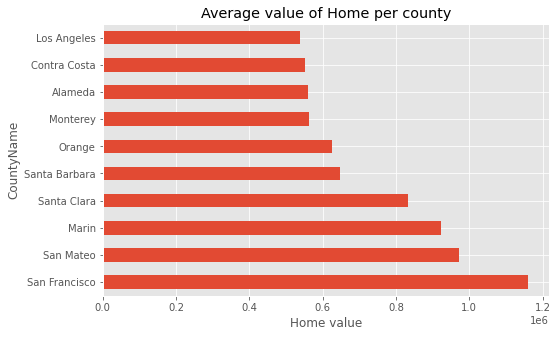

In [24]:
fig =plt.figure(figsize=(8,5))
county.plot.barh()
plt.title('Average value of Home per county')
plt.xlabel('Home value')
plt.show()

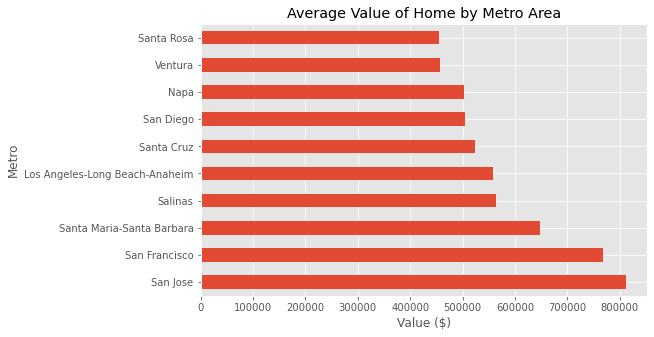

In [25]:
fig = plt.figure(figsize=(8,5))
metro.plot.barh()
plt.title('Average Value of Home by Metro Area')
plt.xlabel('Value ($)')
plt.show()


Here we get a good idea of the average home value per Metro area.

In [26]:
print('Average CA home value' ,round(melted_df['value'].mean()))

Average CA home value 457429


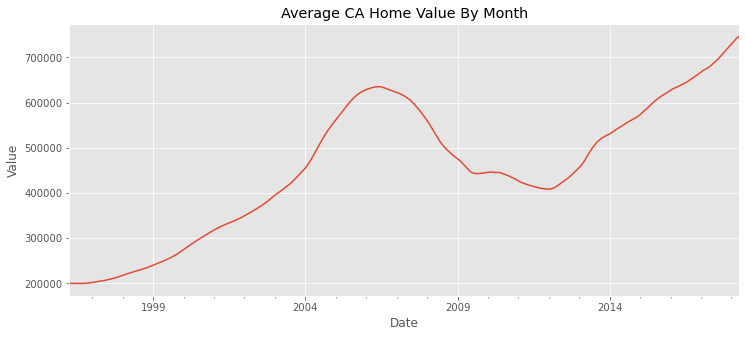

Date
1996-04-01    200220.959596
1996-05-01    200124.831650
1996-06-01    200035.942761
1996-07-01    199965.572391
1996-08-01    199958.754209
Freq: MS, Name: value, dtype: float64


In [27]:
# melted_df = melted_df.asfreq('W-SAT')
# CO2 = df['co2'].resample('MS').mean()
# CO2 = CO2.fillna(CO2.bfill())
monthly_data = melted_df['value'].resample('MS').mean()
monthly_data = monthly_data.fillna(monthly_data.bfill())
monthly_data.plot(figsize=(12,5))
plt.title('Average CA Home Value By Month')
plt.ylabel('Value')
plt.show()
print(monthly_data.head())

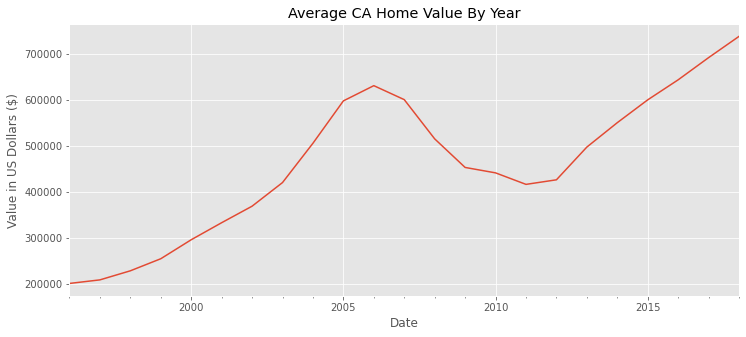

Date
1996-12-31    200285.933408
1997-12-31    208054.924242
1998-12-31    227790.333895
1999-12-31    254072.804433
2000-12-31    295432.870370
Freq: A-DEC, Name: value, dtype: float64


In [28]:
yearly_data = melted_df['value'].resample('A').mean()
yearly_data.plot.line(figsize=(12,5))
plt.title('Average CA Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.show()
print(yearly_data.head())

The monthly and yearly home values seem ot be similar.

Next, we will cut down on variation to ensure we get the true most valuable zip codes.

In [29]:
df_ca.shape

(1224, 270)

In [30]:
#taking into account the last 12months
df_ca.iloc[:,-12:]

,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,3734000,3759300,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,568700,573800,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,385800,390400,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,1812600,1825000,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,944200,955300,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700
...,...,...,...,...,...,...,...,...,...,...,...,...
1219,286000,289600,287700,276300,263900,259000,259800,262600,264400,265900,269400,272500
1220,459300,467500,476900,488600,494100,491200,485700,482600,480900,483600,490500,496300
1221,776100,774300,772800,778200,786100,792700,799100,806900,814600,824300,837100,848700
1222,173100,177600,180900,182600,184200,185700,187300,189100,189900,191600,195700,200100


In [31]:
df_ca['yr_avg']=df_ca.iloc[:,-60:].mean(skipna=True, axis=1)

#Get zipcodes with an average value 2 decile above the median and 2 deciles below.
print(df_ca['yr_avg'].describe(),'\n')

#Calculate the 70% cutoff value (2 decile above).
q_70 = df_ca['yr_avg'].quantile(q=0.70)
print(f'Average Value 70% cutoff value: {round(q_70,2)}')

#Calculate the 30% cutoff value (2 deciles below).
q_30 = df_ca['yr_avg'].quantile(q=0.30)
print(f'Average Value 30% cutoff value: {round(q_30,2)}')

#Get data frame with selected zipcodes.
df_avg = df_ca[(df_ca['yr_avg']<q_70) & (df_ca['yr_avg']>q_30)]
print(f'Amount of zipcodes: {len(df_avg)}')

count    1.224000e+03
mean     6.146968e+05
std      5.553401e+05
min      5.477833e+04
25%      2.826767e+05
50%      4.664775e+05
75%      7.432292e+05
max      5.319428e+06
Name: yr_avg, dtype: float64 

Average Value 70% cutoff value: 654150.17
Average Value 30% cutoff value: 313131.83
Amount of zipcodes: 490


In [32]:
df_avg.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,585700,590900,594700,598500,601300,602800,606100,612400,616200,497491.666667
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,398400,401600,405400,408600,410900,413700,417900,424300,430100,324933.333333
7,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,119500.0,119500.0,119400.0,119300.0,119200.0,...,386900,390600,394300,398600,404200,409700,414300,418500,421100,321008.333333
8,90805,Long Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,128300.0,128100.0,127800.0,127500.0,127100.0,...,430600,434800,439300,443500,447700,451700,455000,457600,459100,374406.666667
9,95630,Folsom,CA,Sacramento,Sacramento,190000.0,189300.0,188500.0,187800.0,187300.0,...,529700,529500,531000,533300,537200,542400,544600,544100,542900,477610.000000


In [33]:
#Calculate historical return on investment
df_avg['ROI'] = (df_avg['2018-04']/df_avg['1996-04'])-1

#Calculate standard deviation of monthly values
df_avg['std'] = df_avg.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df_avg['mean'] = df_avg.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df_avg['CV'] = df_avg['std']/df_avg['mean']

#Show calculated values
df_avg[['ZipCode','std','mean','ROI','CV','CountyName']].head()

,ZipCode,std,mean,ROI,CV,CountyName
1,90250,138601.533036,365464.150943,3.040656,0.379248,Los Angeles
2,94565,104006.852657,263874.339623,2.089799,0.394153,Contra Costa
7,90044,97293.744047,243829.811321,2.523849,0.399023,Los Angeles
8,90805,108971.123756,281955.471698,2.578332,0.386483,Los Angeles
9,95630,106331.603220,373722.264151,1.857368,0.284520,Sacramento


Now that we have cut down on variation of home values, let's select the top 12 that we will model.

**Define coefficient of Variation** ????

In [34]:
df_avg.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,601300,602800,606100,612400,616200,497491.666667,3.040656,138601.533036,365464.150943,0.379248
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,410900,413700,417900,424300,430100,324933.333333,2.089799,104006.852657,263874.339623,0.394153
7,90044,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,119500.0,119500.0,119400.0,119300.0,119200.0,...,404200,409700,414300,418500,421100,321008.333333,2.523849,97293.744047,243829.811321,0.399023
8,90805,Long Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,128300.0,128100.0,127800.0,127500.0,127100.0,...,447700,451700,455000,457600,459100,374406.666667,2.578332,108971.123756,281955.471698,0.386483
9,95630,Folsom,CA,Sacramento,Sacramento,190000.0,189300.0,188500.0,187800.0,187300.0,...,537200,542400,544600,544100,542900,477610.000000,1.857368,106331.603220,373722.264151,0.284520


In [35]:
#find out the top 10 couties with highest ROI
grp_county = df_avg.groupby('CountyName', group_keys=False).sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

# sorted(round(grouped_county,2), reverse=True)[:10]

CountyName
Los Angeles       417.783995
San Diego         147.088794
Orange             88.679465
Riverside          52.076472
Alameda            43.304672
Sacramento         42.831200
Ventura            41.095536
San Bernardino     39.613757
Sonoma             37.354402
Placer             36.219020
Name: ROI, dtype: float64

In [36]:
grp_county.sort_values(ascending=False)[:10].keys() 

Index(['Los Angeles', 'San Diego', 'Orange', 'Riverside', 'Alameda',
       'Sacramento', 'Ventura', 'San Bernardino', 'Sonoma', 'Placer'],
      dtype='object', name='CountyName')

In [37]:
# #Descriptive statistics of coefficients of variance.
# print(df_avg.CV.describe())

# #Define upper limit of CV according to risk profile.
# upper_cv = df_avg.CV.quantile(.6)
# print(f'\nCV upper limit: {upper_cv}')

# #Get the 10 zipcodes with highest ROIs within the firms risk profile.
# df_top10 = df_avg[df_avg['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:10]


# #Get the 10 counties with highest ROIs within the firms risk profile.
# top10_county_df = df_avg[df_avg['CV']<upper_cv].sort_values('ROI', axis=0, ascending=False)[:10]

# #print('\n Top 12 Zipcodes:')
# df_top10[['ZipCode','ROI','CV', 'CountyName']]

In [38]:
df_avg.loc[df_avg['CountyName'] == 'San Luis Obispo']

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
205,93446,Paso Robles,CA,San Luis Obispo,San Luis Obispo,149100.0,148800.0,148600.0,148300.0,147900.0,...,485900,489100,492700,496500,497900,418585.000000,2.339370,108020.566193,330189.056604,0.327148
501,93422,Atascadero,CA,San Luis Obispo,San Luis Obispo,169300.0,169200.0,169000.0,168900.0,168800.0,...,521100,524100,528000,532700,534600,452591.666667,2.157708,118002.769637,367505.660377,0.321091
523,93420,Arroyo Grande,CA,San Luis Obispo,San Luis Obispo,200000.0,200400.0,200900.0,201600.0,202200.0,...,687000,689300,692600,697400,699400,609535.000000,2.497000,160867.203966,485726.037736,0.331189
709,93405,San Luis Obispo,CA,San Luis Obispo,San Luis Obispo,181000.0,181700.0,182500.0,183300.0,184300.0,...,706900,709700,717900,728500,733400,652610.000000,3.051934,161513.696118,492692.452830,0.327818
739,93444,Nipomo,CA,San Luis Obispo,San Luis Obispo,185400.0,186600.0,187900.0,189300.0,190900.0,...,608300,608900,610400,610800,608400,528081.666667,2.281553,138581.362378,435244.905660,0.318399
857,93402,Los Osos,CA,San Luis Obispo,San Luis Obispo,157800.0,156900.0,156000.0,155100.0,154500.0,...,551600,550300,549600,549700,548600,461606.666667,2.476553,118570.293209,360920.377358,0.328522
884,93442,Morro Bay,CA,San Luis Obispo,San Luis Obispo,175800.0,175700.0,175600.0,175700.0,175900.0,...,642900,645500,648600,652500,653200,539821.666667,2.715586,144775.650804,427627.924528,0.338555
887,93433,Grover Beach,CA,San Luis Obispo,San Luis Obispo,147200.0,146700.0,146200.0,145800.0,145500.0,...,515700,514900,516200,519500,519600,442816.666667,2.529891,118366.263343,349582.264151,0.338593
940,93465,Templeton,CA,San Luis Obispo,San Luis Obispo,182600.0,182800.0,183200.0,183600.0,184100.0,...,629900,631900,635800,642000,646100,531740.000000,2.538335,137610.810025,435135.849057,0.316248
977,93428,Cambria,CA,San Luis Obispo,San Luis Obispo,223400.0,223100.0,223000.0,222900.0,223000.0,...,685600,685400,689600,697700,702800,604348.333333,2.145927,159120.458380,502614.716981,0.316585


In [39]:
#Descriptive statistics of coefficients of variance.
print(df_avg.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_avg.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 10 zipcodes with highest ROIs within the firms risk profile.
# df_top10 = df_avg[df_avg['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)


#Get the 10 counties with highest ROIs within the firms risk profile.
df_top10 = df_avg[df_avg['CV']<upper_cv].sort_values('ROI', axis=0, ascending=False)

#find out the top 10 couties with highest ROI
grp_county = df_top10.groupby('CountyName').sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

count    490.000000
mean       0.342695
std        0.045802
min        0.062004
25%        0.316948
50%        0.343743
75%        0.367369
max        0.496292
Name: CV, dtype: float64

CV upper limit: 0.352771200684699


CountyName
San Diego          104.081896
Los Angeles         87.476996
Sonoma              37.354402
Placer              36.219020
Orange              36.115044
Riverside           36.059404
San Luis Obispo     31.452261
Sacramento          31.424705
Ventura             27.954180
Alameda             20.937883
Name: ROI, dtype: float64

Now for each county lets look into the zipcode with the highest ROI value and move onto the time series analysis


In [40]:
# top10_county = ['San Diego', 'Los Angeles', 'Sonoma', 'Placer', 'Orange', 
#                 'Riverside', 'San Luis Obispo', 'Sacramento', 'Ventura', 
#                 'Alameda']

In [41]:
top10_county = list(grp_county.sort_values(ascending=False)[:10].index)
top10_county

['San Diego',
 'Los Angeles',
 'Sonoma',
 'Placer',
 'Orange',
 'Riverside',
 'San Luis Obispo',
 'Sacramento',
 'Ventura',
 'Alameda']

In [42]:
df_top10.shape

(294, 275)

In [43]:
df_top10 = df_top10.loc[df_top10['CountyName'].isin(top10_county)]
df_top10.shape

(204, 275)

In [44]:
df_top10['CountyName'].value_counts()

San Diego          44
Los Angeles        40
Riverside          21
Placer             18
Sacramento         17
Sonoma             16
Orange             14
San Luis Obispo    13
Ventura            13
Alameda             8
Name: CountyName, dtype: int64

In [45]:
df_top10.groupby('CountyName').max()['ROI']

CountyName
Alameda            3.095776
Los Angeles        2.778128
Orange             3.075993
Placer             3.042790
Riverside          2.313076
Sacramento         2.915972
San Diego          3.439456
San Luis Obispo    3.051934
Sonoma             2.591224
Ventura            2.549803
Name: ROI, dtype: float64

In [46]:
df_top10.isna().sum()

ZipCode       0
City          0
State         0
Metro         0
CountyName    0
             ..
yr_avg        0
ROI           3
std           0
mean          0
CV            0
Length: 275, dtype: int64

In [47]:
#Get city and state names for each zip code
# top10_county = ['San Diego', 'Los Angeles', 'Sonoma', 'Placer', 'Orange', 
#                 'Riverside', 'San Luis Obispo ', 'Sacramento', 'Ventura', 
#                 'Alameda']
ziplist = []
for i in top10_county:
    City = df_top10[df_top10['CountyName']==i].City.values[0]
    Metro = df_top10[df_top10['CountyName']==i].Metro.values[0]
    Zipcode = df_top10[df_top10['CountyName']==i].ZipCode.values[0]
    ziplist.append(Zipcode)
    print(f'County : {i} \nCity: {City}, Zipcode: {Zipcode}, Metro: {Metro}\n')

County : San Diego 
City: San Diego, Zipcode: 92101, Metro: San Diego

County : Los Angeles 
City: Torrance, Zipcode: 90504, Metro: Los Angeles-Long Beach-Anaheim

County : Sonoma 
City: Guerneville, Zipcode: 95446, Metro: Santa Rosa

County : Placer 
City: Homewood, Zipcode: 96141, Metro: Sacramento

County : Orange 
City: Orange, Zipcode: 92866, Metro: Los Angeles-Long Beach-Anaheim

County : Riverside 
City: Norco, Zipcode: 92860, Metro: Riverside

County : San Luis Obispo 
City: San Luis Obispo, Zipcode: 93405, Metro: San Luis Obispo

County : Sacramento 
City: Sacramento, Zipcode: 95818, Metro: Sacramento

County : Ventura 
City: Ojai, Zipcode: 93023, Metro: Ventura

County : Alameda 
City: San Leandro, Zipcode: 94577, Metro: San Francisco



## San Diego: Zipcode 92101

In [48]:
ziplist = ['92101', '90504', '95446', '96141', '92866', '92860', '93405', '95818', '93023', '94577']

In [49]:
ts = {}
for zc in ziplist:
    temp_df = melted_df.groupby('ZipCode').get_group(zc).sort_index()['value']
    ts[zc] = temp_df

In [50]:
ts

{'92101': Date
 1996-04-01    147000.0
 1996-05-01    147400.0
 1996-06-01    147700.0
 1996-07-01    148100.0
 1996-08-01    148500.0
                 ...   
 2017-12-01    624900.0
 2018-01-01    625200.0
 2018-02-01    631800.0
 2018-03-01    644200.0
 2018-04-01    652600.0
 Name: value, Length: 265, dtype: float64,
 '90504': Date
 1996-04-01    190200.0
 1996-05-01    190200.0
 1996-06-01    190100.0
 1996-07-01    189900.0
 1996-08-01    189700.0
                 ...   
 2017-12-01    697900.0
 2018-01-01    703100.0
 2018-02-01    708800.0
 2018-03-01    715300.0
 2018-04-01    718600.0
 Name: value, Length: 265, dtype: float64,
 '95446': Date
 1996-04-01    129900.0
 1996-05-01    129400.0
 1996-06-01    128900.0
 1996-07-01    128400.0
 1996-08-01    128000.0
                 ...   
 2017-12-01    447000.0
 2018-01-01    451400.0
 2018-02-01    456800.0
 2018-03-01    463100.0
 2018-04-01    466500.0
 Name: value, Length: 265, dtype: float64,
 '96141': Date
 1996-04-01    1706

In [51]:
ts_df = pd.DataFrame(ts)
ts_df.head()

,92101,90504,95446,96141,92866,92860,93405,95818,93023,94577
Date,,,,,,,,,,
1996-04-01,147000.0,190200.0,129900.0,170600.0,173700.0,162900.0,181000.0,144000.0,202800.0,168100.0
1996-05-01,147400.0,190200.0,129400.0,171800.0,173600.0,162200.0,181700.0,144300.0,201600.0,167600.0
1996-06-01,147700.0,190100.0,128900.0,172900.0,173500.0,161500.0,182500.0,144500.0,200400.0,167100.0
1996-07-01,148100.0,189900.0,128400.0,174000.0,173500.0,160800.0,183300.0,144500.0,199200.0,166600.0
1996-08-01,148500.0,189700.0,128000.0,175100.0,173600.0,160200.0,184300.0,144600.0,198000.0,166200.0


In [52]:
zip_1 = ziplist[0]

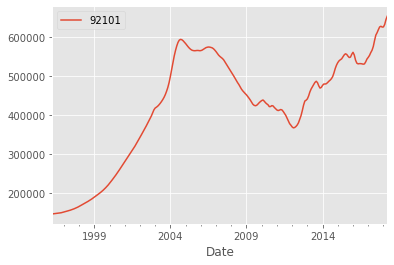

In [53]:
ts_zip1 = ts_df[zip_1].copy()
ax = ts_zip1.plot()
ax.legend()
plt.show()

## Model 1: San Diego (Zipcode 92101)

### Baseline Model

In [54]:
# selected params
d = 1
p = 1
q = 1

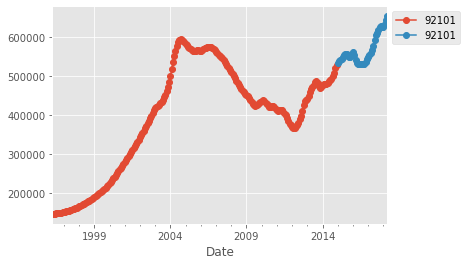

In [55]:
train_size = 0.85 #leaving approximately 3year for test size.
split_idx = round(len(ts_zip1)* train_size)
split_idx

## Split
train = ts_zip1.iloc[:split_idx]
test = ts_zip1.iloc[split_idx:]

## Visualize split
fig,ax= plt.subplots()
kws = dict(ax=ax,marker='o')
train.plot(**kws)
test.plot(**kws)
ax.legend(bbox_to_anchor=[1,1])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92101   No. Observations:                  225
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2186.172
Date:                Fri, 30 Jul 2021   AIC                           4378.344
Time:                        10:55:38   BIC                           4388.579
Sample:                    04-01-1996   HQIC                          4382.475
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8545      0.028     30.691      0.000       0.800       0.909
ma.L1         -0.7447      0.034    -22.066      0.000      -0.811      -0.679
sigma2      1.717e+07   1.81e-10   9.51e+16      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (L1) (Q):                 166.96   Jarque-Bera (JB):                78.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.33
Prob(H) (two-sided):                  0.36   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.48e+32. Standard errors may be unstable.
"""

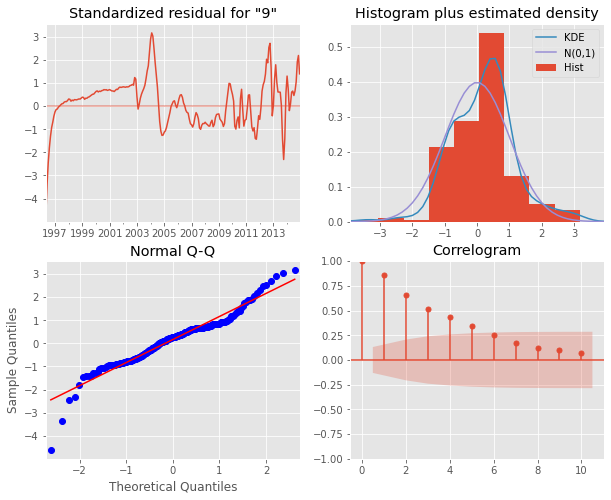

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Baseline model from eye-balled params
model = SARIMAX(train,order=(p,d,q),).fit()
display(model.summary())
model.plot_diagnostics(figsize=(10,8));
plt.show()

In [57]:
## obtaining forecast
from sklearn import metrics
forecast = model.get_forecast(steps=len(test))

In [58]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred

pred_df = forecast_to_df(forecast,zip_1)
pred_df

,lower,upper,prediction
2015-01-01,522605.595442,538850.383548,530727.989495
2015-02-01,521181.403406,545449.226187,533315.314796
2015-03-01,519943.687139,551108.524646,535526.105892
2015-04-01,518665.508443,556164.811388,537415.159916
2015-05-01,517299.090773,560759.507940,539029.299356
2015-06-01,515841.765092,564975.300135,540408.532614
2015-07-01,514304.689798,568869.401509,541587.045653
2015-08-01,512702.796598,572485.302095,542594.049347
2015-09-01,511051.098242,575857.908756,543454.503499
2015-10-01,509363.306605,579016.164410,544189.735508


In [59]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

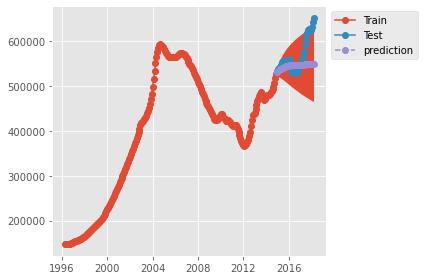

In [60]:
plot_train_test_pred(train,test,pred_df)

plt.show()


## Model 2 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1969.676
Date:                Fri, 30 Jul 2021   AIC                           3943.351
Time:                        10:55:39   BIC                           3950.165
Sample:                             0   HQIC                          3946.102
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0335      0.010      3.394      0.001       0.014       0.053
sigma2      2.722e+06   1.38e+05     19.727      0.000    2.45e+06    2.99e+06
===================================================================================
Ljung-Box (L1) (Q):                  42.82   Jarque-Bera (JB):               252.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              46.81   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

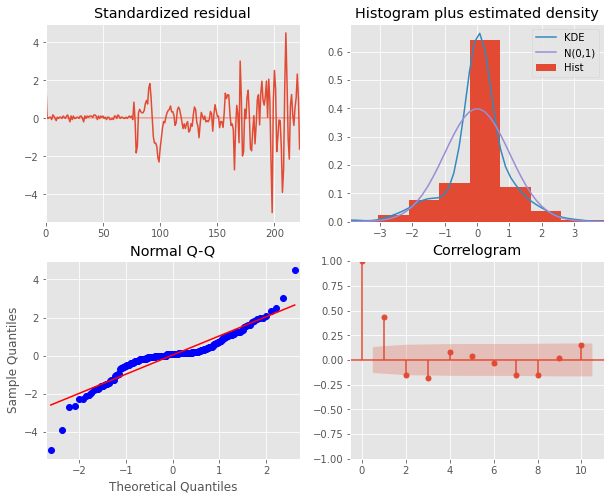

In [61]:
auto_model = auto_arima(train,start_p=0,start_q=0)
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(10,8));

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92101   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2402.061
Date:                Fri, 30 Jul 2021   AIC                           4808.121
Time:                        10:55:40   BIC                           4815.266
Sample:                    04-01-1996   HQIC                          4810.993
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0484      0.007      6.748      0.000       0.034       0.062
sigma2      3.546e+06   1.25e+05     28.369      0.000     3.3e+06    3.79e+06
===================================================================================
Ljung-Box (L1) (Q):                  36.26   Jarque-Bera (JB):               280.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.11   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

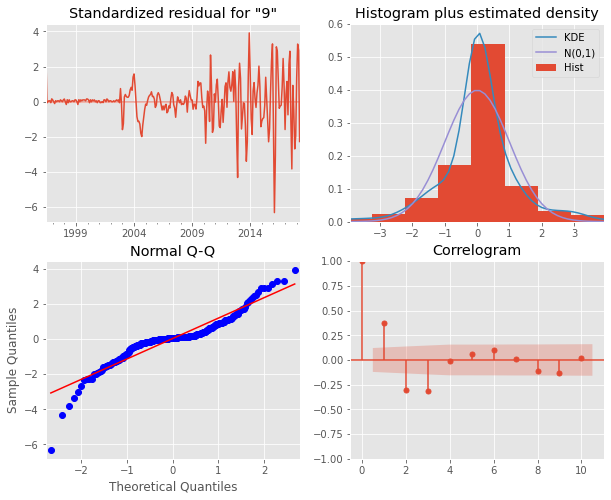

In [62]:
model3 = SARIMAX(ts_zip1,order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order).fit()
display(model3.summary())
model3.plot_diagnostics(figsize=(10,8));

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

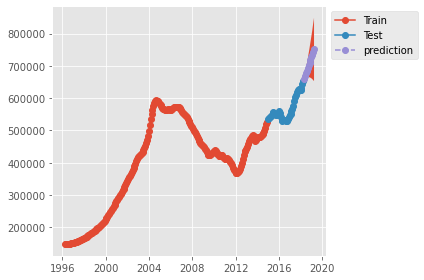

In [63]:
pred = model3.get_forecast(steps=12)#start=test.index[0],end=test.index[-1])
pred_df = forecast_to_df(pred,zip_1)
display(plot_train_test_pred(train,test,pred_df));
plt.show()

In [64]:
ziplist

['92101',
 '90504',
 '95446',
 '96141',
 '92866',
 '92860',
 '93405',
 '95818',
 '93023',
 '94577']

92101


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92101   No. Observations:                  265
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -2917.063
Date:                Fri, 30 Jul 2021   AIC                           5848.126
Time:                        11:08:05   BIC                           5873.157
Sample:                    04-01-1996   HQIC                          5858.184
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6872      0.028     24.480      0.000       0.632       0.742
ar.L2         -0.0909      0.009    -10.669      0.000      -0.108      -0.074
ar.L3          0.1605      0.004     45.170      0.000       0.154       0.167
ar.L4         -0.1978      0.006    -31.152      0.000      -0.210      -0.185
ar.L5          0.1708      0.003     53.608      0.000       0.165       0.177
ma.L1         -0.4462      0.029    -15.507      0.000      -0.503      -0.390
sigma2      3.761e+06   1.07e-09   3.51e+15      0.000    3.76e+06    3.76e+06
===================================================================================
Ljung-Box (L1) (Q):                  87.43   Jarque-Bera (JB):              1077.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -1.53
Prob(H) (two-sided):                  0.88   Kurtosis:                        12.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.68e+30. Standard errors may be unstable.
"""

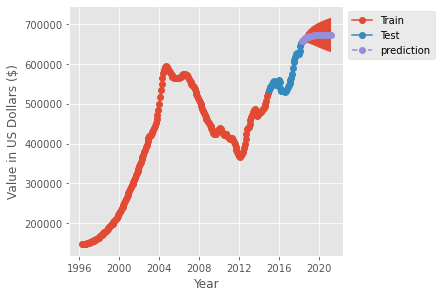

------------------------------------------------------------

90504


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  90504   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2539.107
Date:                Fri, 30 Jul 2021   AIC                           5084.214
Time:                        11:08:07   BIC                           5094.942
Sample:                    04-01-1996   HQIC                          5088.525
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9295      0.017     55.608      0.000       0.897       0.962
ma.L1         -0.8725      0.021    -41.626      0.000      -0.914      -0.831
sigma2      1.284e+07   1.17e-10    1.1e+17      0.000    1.28e+07    1.28e+07
===================================================================================
Ljung-Box (L1) (Q):                 226.27   Jarque-Bera (JB):                38.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.66
Prob(H) (two-sided):                  0.79   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.31e+32. Standard errors may be unstable.
"""

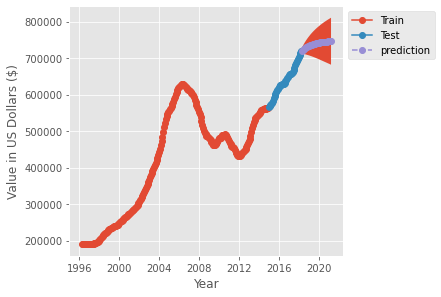

------------------------------------------------------------

95446


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  95446   No. Observations:                  265
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2463.877
Date:                Fri, 30 Jul 2021   AIC                           4935.755
Time:                        11:08:11   BIC                           4950.059
Sample:                    04-01-1996   HQIC                          4941.503
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9458      0.020     46.417      0.000       0.906       0.986
ma.L1         -0.8571      0.023    -37.081      0.000      -0.902      -0.812
ma.L2         -0.0374      0.009     -4.110      0.000      -0.055      -0.020
sigma2      7.134e+06   2.76e-10   2.58e+16      0.000    7.13e+06    7.13e+06
===================================================================================
Ljung-Box (L1) (Q):                 200.61   Jarque-Bera (JB):                86.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.95
Prob(H) (two-sided):                  0.60   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+33. Standard errors may be unstable.
"""

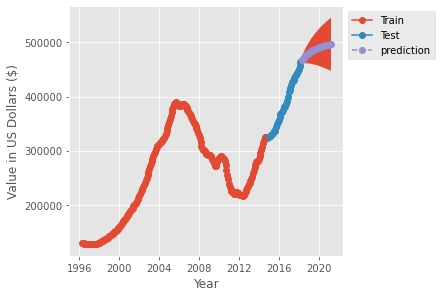

------------------------------------------------------------

96141


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  96141   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2506.975
Date:                Fri, 30 Jul 2021   AIC                           5017.951
Time:                        11:08:12   BIC                           5025.095
Sample:                    04-01-1996   HQIC                          5020.822
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0532      0.009      5.868      0.000       0.035       0.071
sigma2      9.522e+06   6.85e-12   1.39e+18      0.000    9.52e+06    9.52e+06
===================================================================================
Ljung-Box (L1) (Q):                  35.47   Jarque-Bera (JB):                68.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.39   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.5e+33. Standard errors may be unstable.
"""

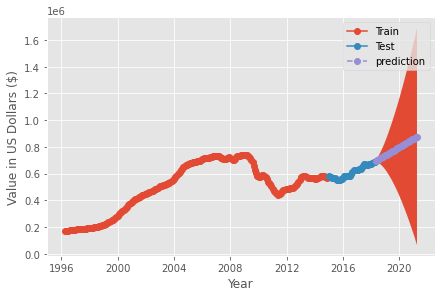

------------------------------------------------------------

92866


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92866   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2539.324
Date:                Fri, 30 Jul 2021   AIC                           5084.647
Time:                        11:08:16   BIC                           5095.375
Sample:                    04-01-1996   HQIC                          5088.958
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9359      0.015     64.344      0.000       0.907       0.964
ma.L1         -0.8737      0.019    -45.852      0.000      -0.911      -0.836
sigma2      1.284e+07   5.21e-11   2.47e+17      0.000    1.28e+07    1.28e+07
===================================================================================
Ljung-Box (L1) (Q):                 215.41   Jarque-Bera (JB):                49.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.67
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+33. Standard errors may be unstable.
"""

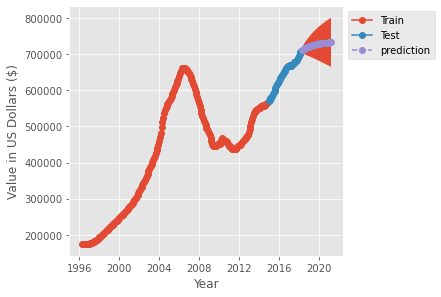

------------------------------------------------------------

92860


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92860   No. Observations:                  265
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2548.852
Date:                Fri, 30 Jul 2021   AIC                           5109.704
Time:                        11:08:19   BIC                           5131.160
Sample:                    04-01-1996   HQIC                          5118.325
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0808      0.005     16.266      0.000       0.071       0.091
ar.L2          0.0767      0.005     13.992      0.000       0.066       0.087
ar.L3          0.0765      0.006     11.871      0.000       0.064       0.089
ar.L4          0.0779      0.007     11.398      0.000       0.065       0.091
ar.L5          0.0800      0.007     11.052      0.000       0.066       0.094
sigma2      1.368e+07    1.6e-11   8.57e+17      0.000    1.37e+07    1.37e+07
===================================================================================
Ljung-Box (L1) (Q):                 214.89   Jarque-Bera (JB):               392.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+33. Standard errors may be unstable.
"""

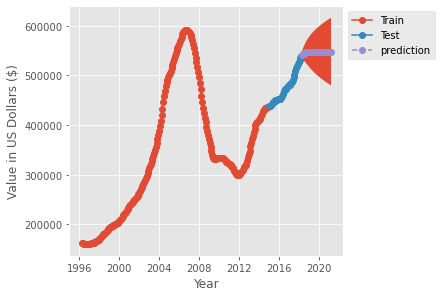

------------------------------------------------------------

93405


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  93405   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2546.633
Date:                Fri, 30 Jul 2021   AIC                           5099.266
Time:                        11:08:22   BIC                           5109.994
Sample:                    04-01-1996   HQIC                          5103.577
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9449      0.016     60.052      0.000       0.914       0.976
ma.L1         -0.8914      0.021    -42.989      0.000      -0.932      -0.851
sigma2      1.367e+07   1.15e-10   1.19e+17      0.000    1.37e+07    1.37e+07
===================================================================================
Ljung-Box (L1) (Q):                 201.96   Jarque-Bera (JB):                 5.53
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.30   Skew:                            -0.24
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+33. Standard errors may be unstable.
"""

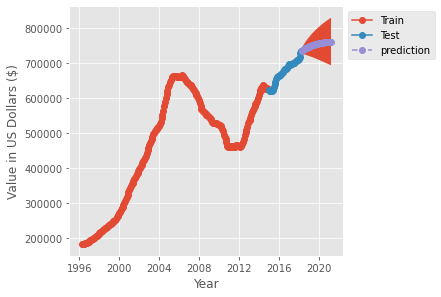

------------------------------------------------------------

95818


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  95818   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2482.895
Date:                Fri, 30 Jul 2021   AIC                           4971.790
Time:                        11:08:27   BIC                           4982.518
Sample:                    04-01-1996   HQIC                          4976.101
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9099      0.019     49.149      0.000       0.874       0.946
ma.L1         -0.8372      0.023    -36.314      0.000      -0.882      -0.792
sigma2      8.247e+06   1.49e-10   5.54e+16      0.000    8.25e+06    8.25e+06
===================================================================================
Ljung-Box (L1) (Q):                 213.12   Jarque-Bera (JB):                56.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.73
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.62e+35. Standard errors may be unstable.
"""

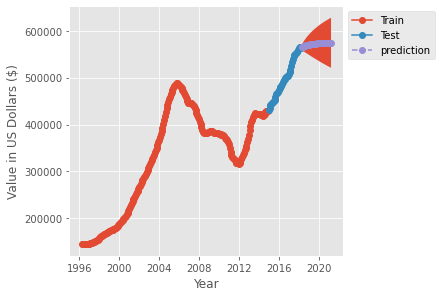

------------------------------------------------------------

93023


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  93023   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2567.016
Date:                Fri, 30 Jul 2021   AIC                           5140.033
Time:                        11:08:30   BIC                           5150.761
Sample:                    04-01-1996   HQIC                          5144.344
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9363      0.015     63.384      0.000       0.907       0.965
ma.L1         -0.8818      0.019    -46.965      0.000      -0.919      -0.845
sigma2      1.594e+07   3.66e-11   4.36e+17      0.000    1.59e+07    1.59e+07
===================================================================================
Ljung-Box (L1) (Q):                 219.88   Jarque-Bera (JB):                42.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.79
Prob(H) (two-sided):                  0.75   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.43e+33. Standard errors may be unstable.
"""

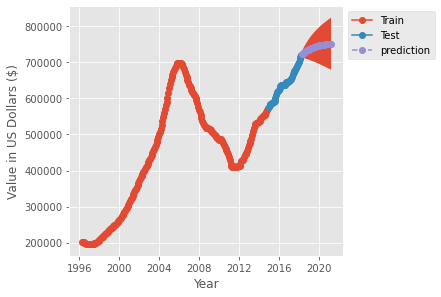

------------------------------------------------------------

94577


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  94577   No. Observations:                  265
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2562.685
Date:                Fri, 30 Jul 2021   AIC                           5137.371
Time:                        11:08:33   BIC                           5158.827
Sample:                    04-01-1996   HQIC                          5145.992
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0882      0.005     17.489      0.000       0.078       0.098
ar.L2          0.0756      0.006     12.743      0.000       0.064       0.087
ar.L3          0.0697      0.007      9.555      0.000       0.055       0.084
ar.L4          0.0725      0.008      9.544      0.000       0.058       0.087
ar.L5          0.0784      0.008     10.198      0.000       0.063       0.093
sigma2       1.53e+07    1.6e-11   9.55e+17      0.000    1.53e+07    1.53e+07
===================================================================================
Ljung-Box (L1) (Q):                 203.26   Jarque-Bera (JB):               360.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -1.55
Prob(H) (two-sided):                  0.82   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+31. Standard errors may be unstable.
"""

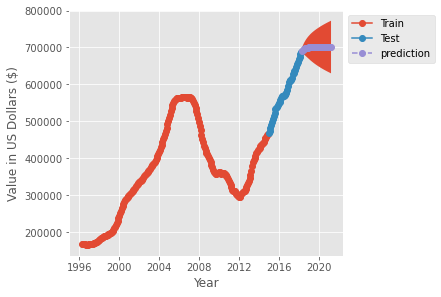

------------------------------------------------------------



In [70]:

RESULTS = {}

for zc in ziplist:
    print(zc)
    
    ## Make empty dict for district data
    zipcode_d = {}
    
    ## Copy Time Series
    ts_final = ts_df[zc].copy()
    
    ## Train Test Split Index
    train_size = 0.85
    split_idx = round(len(ts_df)* train_size)

    ## Split
    train = ts_final.iloc[:split_idx]
    test = ts_final.iloc[split_idx:]
    
    
    ## Get best params using auto_arima
    gridsearch_model = auto_arima(ts_final,start_p=0,start_q=0)
    model3 = SARIMAX(ts_final,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## Get predictions
    pred  = model3.get_forecast(steps=36)#start=test.index[0],end=test.index[-1])
    pred_df = forecast_to_df(pred,zc)

    ## Save info to dict
    zipcode_d['pred_df'] = pred_df
    zipcode_d['model'] = model3
    zipcode_d['train'] = train
    zipcode_d['test'] = test
    
    ## Display Results
    display(model3.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.xlabel('Year')
    plt.ylabel('Value in US Dollars ($)')
    plt.savefig('images/' + zc + 'prediction' + '.png')
    plt.show()
    
    
    ## Save district dict in RESULTS
    RESULTS[zc] = zipcode_d
    print('---'*20,end='\n\n')

In [ ]:
# (df_top10['ROI'])

# Step 6: Interpreting Results